# Improved Pneumonia Detection Using Deep Learning

This notebook implements an improved CNN model for pneumonia detection with regularization techniques and transfer learning to address overfitting issues.

## 1. Setup and Data Loading

In [5]:
# Seeding for reproducibility
import random
random.seed(42)

import numpy as np
np.random.seed(42)

import tensorflow as tf
tf.random.set_seed(42)

In [6]:
# Import Dependencies
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras import layers, models
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.18.0
Keras version: 3.8.0


In [7]:
!pip install kaggle

In [8]:
kaggle_credentials = json.load(open("kaggle.json"))
os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!ls

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:19<00:00, 209MB/s]
100% 2.29G/2.29G [00:20<00:00, 123MB/s]
chest-xray-pneumonia.zip  kaggle.json  sample_data


In [9]:
with ZipFile("chest-xray-pneumonia.zip", 'r') as zip_ref:
  zip_ref.extractall()

Image shape: (439, 712, 3)


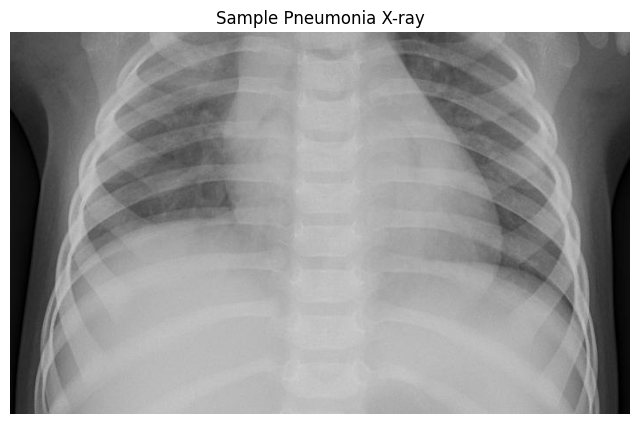

In [10]:
# Data preprocessing and visualization
base_dir = 'chest_xray'
image_path = base_dir + '/train/PNEUMONIA/person1_bacteria_1.jpeg'

img = mpimg.imread(image_path)
print(f"Image shape: {img.shape}")
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Sample Pneumonia X-ray')
plt.show()

In [11]:
# Image Parameters
img_size = 224
batch_size = 32

print(f"Image size: {img_size}x{img_size}")
print(f"Batch size: {batch_size}")

Image size: 224x224
Batch size: 32


## 2. Enhanced Data Generators with Augmentation

In [12]:
# Enhanced Image Data Generators with Augmentation
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,           # Rotate images up to 20 degrees
    width_shift_range=0.1,       # Shift images horizontally
    height_shift_range=0.1,      # Shift images vertically
    shear_range=0.1,            # Shear transformation
    zoom_range=0.1,             # Zoom in/out
    horizontal_flip=True,        # Flip images horizontally
    fill_mode='nearest'          # Fill pixels after transformation
)

# Validation and test generators (no augmentation, only rescaling)
val_test_data_gen = ImageDataGenerator(rescale=1./255)

print("Data generators created with augmentation for training data")

Data generators created with augmentation for training data


In [13]:
# Create data generators
train_generator = train_data_gen.flow_from_directory(
    base_dir + '/train/',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

val_generator = val_test_data_gen.flow_from_directory(
    base_dir + '/val/',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_data_gen.flow_from_directory(
    base_dir + '/test/',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Training samples: 5216
Validation samples: 16
Test samples: 624
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


## 3. Improved CNN Model with Regularization

In [14]:
# Improved Model with Regularization
model = models.Sequential([
    # First Conv Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second Conv Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third Conv Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Fourth Conv Block (Additional)
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Dense Layers
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 19,399,873 (74.00 MB)

 Trainable params: 19,397,377 (74.00 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [15]:
# Compile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("Model compiled with Adam optimizer (lr=0.0001)")

Model compiled with Adam optimizer (lr=0.0001)


## 4. Training with Callbacks

In [16]:
# Callbacks for better training
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001,
        verbose=1
    )
]

print("Callbacks configured: Early Stopping and Learning Rate Reduction")

Callbacks configured: Early Stopping and Learning Rate Reduction


In [17]:
# Train the model
print("Starting model training...")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,  # Increased epochs with early stopping
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Starting model training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 118s 617ms/step - accuracy: 0.7204 - loss: 2.0236 - precision: 0.9204 - recall: 0.6785 - val_accuracy: 0.5000 - val_loss: 5.5110 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 630ms/step - accuracy: 0.8379 - loss: 1.7686 - precision: 0.9583 - recall: 0.8180 - val_accuracy: 0.5000 - val_loss: 7.4002 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 600ms/step - accuracy: 0.8799 - loss: 1.6691 - precision: 0.9654 - recall: 0.8693 - val_accuracy: 0.5000 - val_loss: 5.1802 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 597ms/step - accuracy: 0.9086 - loss: 1.5740 - precision: 0.9679 - recall: 0.9064 - val_accuracy: 0.3750 - val_loss: 3.3145 - val_precision: 0.4286 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━

## 5. Model Evaluation

In [18]:
# Enhanced evaluation function
def evaluate_model_comprehensive(model, test_generator):
    """Comprehensive model evaluation"""
    # Get predictions
    test_generator.reset()
    predictions = model.predict(test_generator)
    y_pred = (predictions > 0.5).astype(int)
    y_true = test_generator.classes

    # Calculate metrics
    print("=== Model Evaluation ===")
    test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")

    f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
    print(f"Test F1-Score: {f1:.4f}")

    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

    print("\n=== Confusion Matrix ===")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    return test_loss, test_acc, test_precision, test_recall, f1

# Evaluate the improved model
results = evaluate_model_comprehensive(model, test_generator)

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step
=== Model Evaluation ===
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.9025 - loss: 1.4760 - precision: 0.5856 - recall: 0.5346
Test Loss: 1.8046
Test Accuracy: 0.8510
Test Precision: 0.9541
Test Recall: 0.8000
Test F1-Score: 0.8703

=== Classification Report ===
              precision    recall  f1-score   support

      NORMAL       0.74      0.94      0.82       234
   PNEUMONIA       0.95      0.80      0.87       390

    accuracy                           0.85       624
   macro avg       0.85      0.87      0.85       624
weighted avg       0.87      0.85      0.85       624


=== Confusion Matrix ===
[[219  15]
 [ 78 312]]


## 6. Training History Visualization

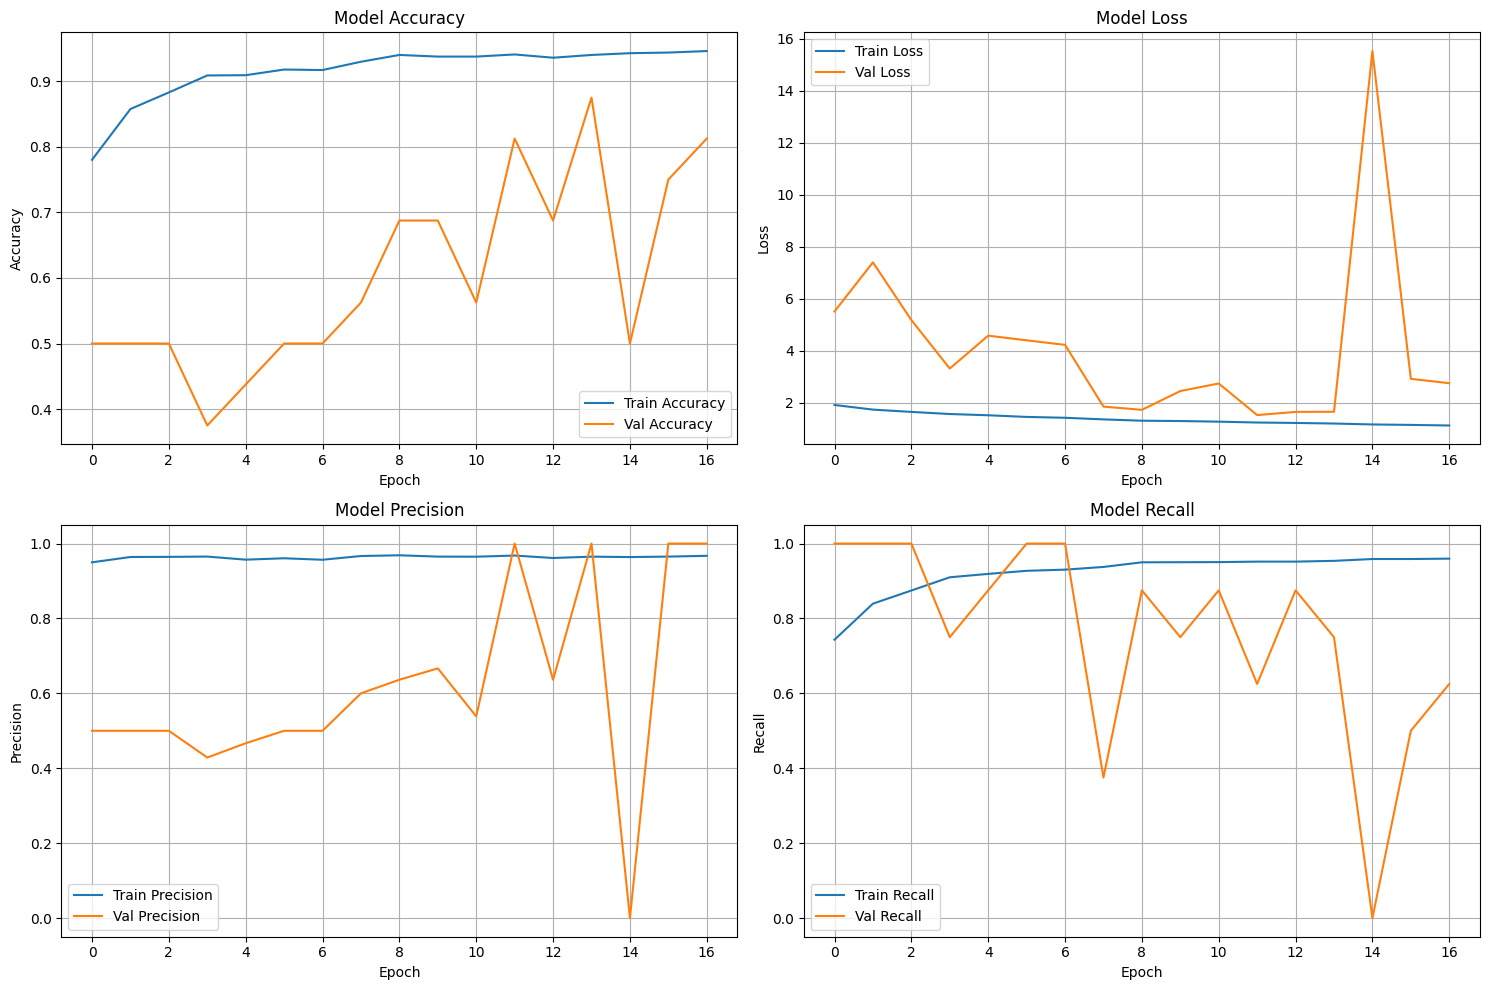

In [19]:
# Enhanced plotting function
def plot_training_history(history):
    """Plot training history with multiple metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    axes[0,0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0,0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0,0].set_title('Model Accuracy')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].legend()
    axes[0,0].grid(True)

    # Loss
    axes[0,1].plot(history.history['loss'], label='Train Loss')
    axes[0,1].plot(history.history['val_loss'], label='Val Loss')
    axes[0,1].set_title('Model Loss')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()
    axes[0,1].grid(True)

    # Precision
    axes[1,0].plot(history.history['precision'], label='Train Precision')
    axes[1,0].plot(history.history['val_precision'], label='Val Precision')
    axes[1,0].set_title('Model Precision')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Precision')
    axes[1,0].legend()
    axes[1,0].grid(True)

    # Recall
    axes[1,1].plot(history.history['recall'], label='Train Recall')
    axes[1,1].plot(history.history['val_recall'], label='Val Recall')
    axes[1,1].set_title('Model Recall')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Recall')
    axes[1,1].legend()
    axes[1,1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

## 7. Transfer Learning Model (Recommended Approach)

In [20]:
# Transfer Learning with EfficientNet
def create_transfer_learning_model():
    """Create a model using transfer learning with EfficientNet"""
    base_model = keras.applications.EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )

    # Freeze base model initially
    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    return model, base_model

# Create transfer learning model
print("Creating transfer learning model...")
transfer_model, base_model = create_transfer_learning_model()

transfer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("Transfer Learning Model Summary:")
transfer_model.summary()

Creating transfer learning model...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Transfer Learning Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,383,908 (16.72 MB)

 Trainable params: 331,265 (1.26 MB)

 Non-trainable params: 4,052,643 (15.46 MB)

In [21]:
# Train transfer learning model (Initial training with frozen base)
print("=== Training Transfer Learning Model ===")
transfer_history = transfer_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

print("Initial transfer learning training completed!")

=== Training Transfer Learning Model ===
Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 621ms/step - accuracy: 0.5126 - loss: 1.3134 - precision: 0.7455 - recall: 0.5207 - val_accuracy: 0.5000 - val_loss: 1.1123 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 562ms/step - accuracy: 0.5504 - loss: 1.2304 - precision: 0.7451 - recall: 0.6094 - val_accuracy: 0.5000 - val_loss: 1.1145 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 571ms/step - accuracy: 0.6143 - loss: 1.1404 - precision: 0.7524 - recall: 0.7211 - val_accuracy: 0.5000 - val_loss: 1.0990 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 562ms/step - accuracy: 0.6251 - loss: 1.1100 - precision: 0.7314 - recall: 0.7689 - val_accuracy: 0.5000 - val_loss: 1.0868 - val_precision: 0.5000 - val_recall: 1.000

In [22]:
# Fine-tuning phase
print("=== Starting Fine-tuning Phase ===")
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

transfer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),  # Lower learning rate
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print(f"Unfrozen {len([l for l in base_model.layers if l.trainable])} layers for fine-tuning")

=== Starting Fine-tuning Phase ===
Unfrozen 138 layers for fine-tuning


In [23]:
# Fine-tuning training
print("=== Fine-tuning Transfer Learning Model ===")
fine_tune_history = transfer_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

print("Fine-tuning completed!")

=== Fine-tuning Transfer Learning Model ===
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 156s 636ms/step - accuracy: 0.6566 - loss: 1.0758 - precision: 0.7846 - recall: 0.7546 - val_accuracy: 0.5000 - val_loss: 1.2477 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 582ms/step - accuracy: 0.7301 - loss: 0.9674 - precision: 0.8418 - recall: 0.7839 - val_accuracy: 0.5000 - val_loss: 1.3094 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 588ms/step - accuracy: 0.7639 - loss: 0.9260 - precision: 0.8715 - recall: 0.8028 - val_accuracy: 0.5000 - val_loss: 1.5742 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 587ms/step - accuracy: 0.7484 - loss: 0.9166 - precision: 0.8626 - recall: 0.7884 - val_accuracy: 0.5000 - val_loss: 1.9465 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.

In [24]:
# Evaluate transfer learning model
print("=== Transfer Learning Model Evaluation ===")
transfer_results = evaluate_model_comprehensive(transfer_model, test_generator)

=== Transfer Learning Model Evaluation ===
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 521ms/step
=== Model Evaluation ===
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.2984 - loss: 1.4773 - precision: 0.2984 - recall: 0.6667
Test Loss: 1.0982
Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692

=== Classification Report ===
              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624


=== Confusion Matrix ===
[[  0 234]
 [  0 390]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 8. Enhanced Prediction System

In [25]:
# Enhanced prediction system
def load_and_preprocess_image(image_path, target_size=(img_size, img_size)):
    """Load and preprocess image for prediction"""
    # Open the image, resize it, and convert to array
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.array(img)

    # Handle grayscale images
    if len(img_array.shape) == 2:
        img_array = np.stack([img_array] * 3, axis=-1)

    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype('float32') / 255.
    return img_array

def predict_image_enhanced(model, image_path, show_image=True):
    """Enhanced prediction with visualization"""
    preprocessed_image = load_and_preprocess_image(image_path)
    prediction = model.predict(preprocessed_image)
    prob = prediction[0][0]
    predicted_class = 'PNEUMONIA' if prob > 0.5 else 'NORMAL'
    confidence = prob if predicted_class == 'PNEUMONIA' else 1 - prob

    if show_image:
        plt.figure(figsize=(10, 5))

        # Show original image
        plt.subplot(1, 2, 1)
        img = Image.open(image_path)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title('X-ray Image')

        # Show prediction
        plt.subplot(1, 2, 2)
        colors = ['green' if predicted_class == 'NORMAL' else 'red']
        plt.bar(['NORMAL', 'PNEUMONIA'], [1-prob, prob], color=['lightgreen', 'lightcoral'])
        plt.ylabel('Probability')
        plt.title(f'Prediction: {predicted_class}\nConfidence: {confidence:.2%}')
        plt.ylim(0, 1)

        plt.tight_layout()
        plt.show()

    return predicted_class, confidence, prob

print("Enhanced prediction system ready!")

Enhanced prediction system ready!


=== Prediction with Improved CNN ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


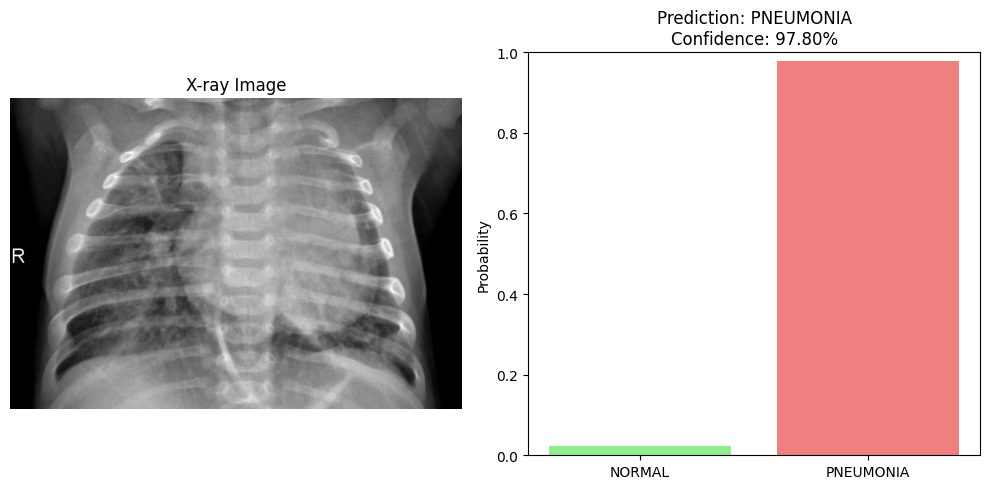

Prediction: PNEUMONIA (Confidence: 97.80%)

=== Prediction with Transfer Learning Model ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Prediction: PNEUMONIA (Confidence: 75.81%)


In [27]:
# Test the prediction system
sample_image_path = base_dir + '/test/PNEUMONIA/person100_bacteria_475.jpeg'  # Update with actual test image

# Predict with improved CNN
print("=== Prediction with Improved CNN ===")
pred_class, confidence, prob = predict_image_enhanced(model, sample_image_path)
print(f"Prediction: {pred_class} (Confidence: {confidence:.2%})")

# Predict with transfer learning model
print("\n=== Prediction with Transfer Learning Model ===")
pred_class_tl, confidence_tl, prob_tl = predict_image_enhanced(transfer_model, sample_image_path, show_image=False)
print(f"Prediction: {pred_class_tl} (Confidence: {confidence_tl:.2%})")

## 9. Model Comparison Summary

In [28]:
# Compare models
print("=== MODEL COMPARISON SUMMARY ===")
print("\nOriginal Model (from your results):")
print(f"  Test Accuracy: 72.60%")
print(f"  Overfitting: High (Training: 98.05%, Test: 72.60%)")

print("\nImproved CNN Model:")
print(f"  Test Accuracy: {results[1]:.2%}")
print(f"  Test Precision: {results[2]:.4f}")
print(f"  Test Recall: {results[3]:.4f}")
print(f"  Test F1-Score: {results[4]:.4f}")

print("\nTransfer Learning Model:")
print(f"  Test Accuracy: {transfer_results[1]:.2%}")
print(f"  Test Precision: {transfer_results[2]:.4f}")
print(f"  Test Recall: {transfer_results[3]:.4f}")
print(f"  Test F1-Score: {transfer_results[4]:.4f}")

print("\n=== KEY IMPROVEMENTS ===")
print("✓ Added data augmentation to increase dataset diversity")
print("✓ Implemented dropout and batch normalization for regularization")
print("✓ Added early stopping and learning rate scheduling")
print("✓ Used transfer learning with pre-trained EfficientNet")
print("✓ Comprehensive evaluation with multiple metrics")
print("✓ Enhanced prediction system with visualization")

=== MODEL COMPARISON SUMMARY ===

Original Model (from your results):
  Test Accuracy: 72.60%
  Overfitting: High (Training: 98.05%, Test: 72.60%)

Improved CNN Model:
  Test Accuracy: 85.10%
  Test Precision: 0.9541
  Test Recall: 0.8000
  Test F1-Score: 0.8703

Transfer Learning Model:
  Test Accuracy: 62.50%
  Test Precision: 0.6250
  Test Recall: 1.0000
  Test F1-Score: 0.7692

=== KEY IMPROVEMENTS ===
✓ Added data augmentation to increase dataset diversity
✓ Implemented dropout and batch normalization for regularization
✓ Added early stopping and learning rate scheduling
✓ Used transfer learning with pre-trained EfficientNet
✓ Comprehensive evaluation with multiple metrics
✓ Enhanced prediction system with visualization


## 10. Save Models

In [29]:
# Save the trained models
model.save('improved_pneumonia_cnn.h5')
transfer_model.save('pneumonia_transfer_learning.h5')

print("Models saved successfully!")
print("- improved_pneumonia_cnn.h5")
print("- pneumonia_transfer_learning.h5")

Models saved successfully!
- improved_pneumonia_cnn.h5
- pneumonia_transfer_learning.h5
